# **Parte 1 - Práctica**

In [ ]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## **AlexNet - CIFAR10**

In [ ]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(227),  # Resize images to 227x227
    transforms.ToTensor(),   # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

In [ ]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Prepare the data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 43744267.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


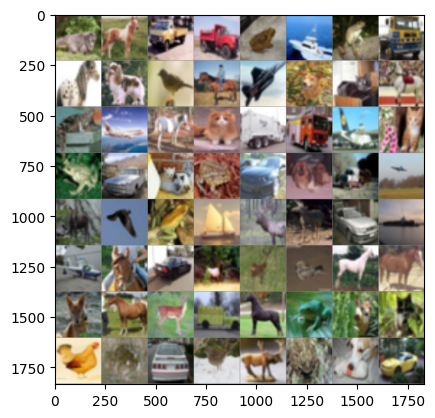

In [ ]:
# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # First Conv Layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),           # Second Conv Layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # Third Conv Layer
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # Fourth Conv Layer
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # Fifth Conv Layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # Flattened dimension from feature map
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the model, criterion, and optimizer
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()  # Standard loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Set the model to training mode

        # Training phase
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Test Accuracy: {accuracy:.2f}%")

    print("Finished Training")

In [ ]:
# Call the training function
train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=20)

[Epoch 1, Batch 100] Loss: 2.121
[Epoch 1, Batch 200] Loss: 1.851
[Epoch 1, Batch 300] Loss: 1.741
[Epoch 1, Batch 400] Loss: 1.648
[Epoch 1, Batch 500] Loss: 1.568
[Epoch 1, Batch 600] Loss: 1.540
[Epoch 1, Batch 700] Loss: 1.538
Epoch 1, Test Accuracy: 49.38%
[Epoch 2, Batch 100] Loss: 1.430
[Epoch 2, Batch 200] Loss: 1.430
[Epoch 2, Batch 300] Loss: 1.398
[Epoch 2, Batch 400] Loss: 1.398
[Epoch 2, Batch 500] Loss: 1.381
[Epoch 2, Batch 600] Loss: 1.344
[Epoch 2, Batch 700] Loss: 1.331
Epoch 2, Test Accuracy: 55.43%
[Epoch 3, Batch 100] Loss: 1.284
[Epoch 3, Batch 200] Loss: 1.261
[Epoch 3, Batch 300] Loss: 1.241
[Epoch 3, Batch 400] Loss: 1.235
[Epoch 3, Batch 500] Loss: 1.253
[Epoch 3, Batch 600] Loss: 1.239
[Epoch 3, Batch 700] Loss: 1.233
Epoch 3, Test Accuracy: 57.37%
[Epoch 4, Batch 100] Loss: 1.139
[Epoch 4, Batch 200] Loss: 1.161
[Epoch 4, Batch 300] Loss: 1.136
[Epoch 4, Batch 400] Loss: 1.136
[Epoch 4, Batch 500] Loss: 1.168
[Epoch 4, Batch 600] Loss: 1.145
[Epoch 4, Batch 